# 1. Load dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [14]:
df = pd.read_csv('~/aiffel/dataset/E6_stock_prediction/005930.KS.csv',
                index_col='Date',
                 parse_dates=True) 
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-08-13,43500.0,43500.0,42950.0,43000.0,43000.0,7276979.0
2019-08-14,43900.0,44250.0,43500.0,43700.0,43700.0,8750135.0
2019-08-16,43800.0,43900.0,43300.0,43900.0,43900.0,9528115.0
2019-08-19,44350.0,44350.0,43500.0,43600.0,43600.0,6014218.0
2019-08-20,43950.0,44600.0,43550.0,44450.0,44450.0,8434205.0


In [15]:
# Time Series 생성
ts = pd.Series(df['Adj Close'])
ts.head()

Date
2019-08-13    43000.0
2019-08-14    43700.0
2019-08-16    43900.0
2019-08-19    43600.0
2019-08-20    44450.0
Name: Adj Close, dtype: float64

In [16]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

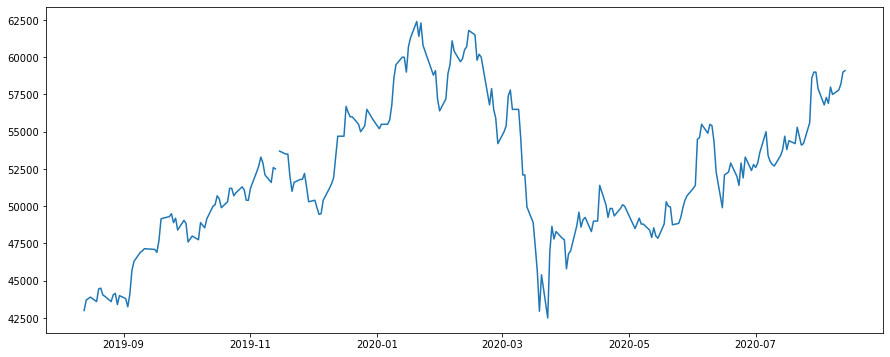

In [17]:
plt.plot(ts)

# 2. Preprocess

### remove NaN

In [18]:
# 결측치 처리
ts[ts.isna()]

Date
2019-11-14   NaN
Name: Adj Close, dtype: float64

In [19]:
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Adj Close, dtype: float64)

### apply log function

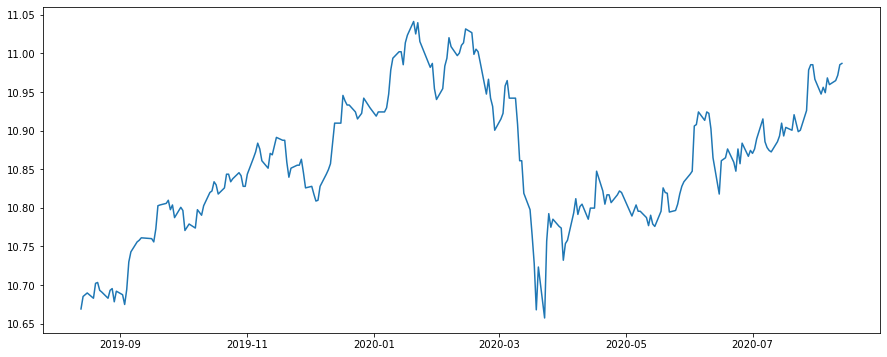

In [21]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

# 3. Cheak stationary

### Rolling_statistics

In [23]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열
    
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

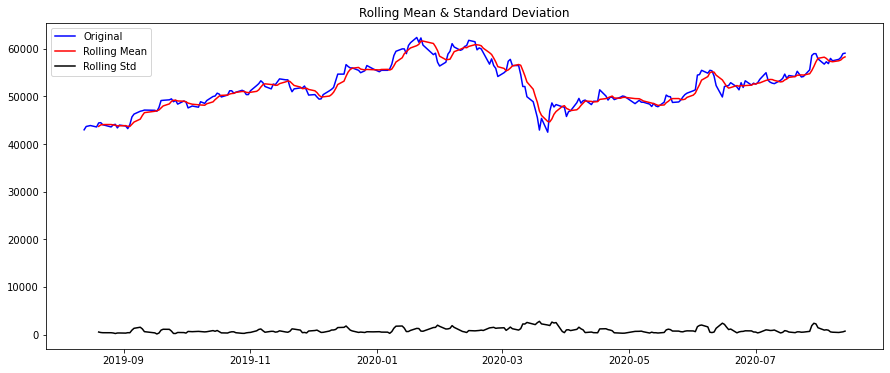

In [36]:
plot_rolling_statistics(ts, window=5)

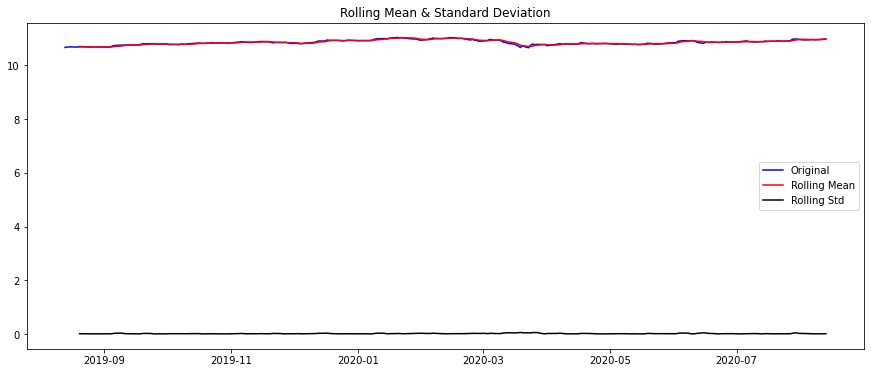

In [35]:
plot_rolling_statistics(ts_log, window=5)

### Augmented Dicky-Fuller Test

In [29]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    
    result = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        result['Critical Value (%s)' % key] = value
    print(result)

In [33]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -2.164843
p-value                          0.219252
#Lags Used                       2.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


In [30]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -2.226455
p-value                          0.196784
#Lags Used                       2.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


### Time Series Decomposition
- seperate trend
    - diffrence Moving average(=rolling mean)
- seperate seasonality
    - Differencing
    - X(t+h) - X(t)

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose

def do_ts_decomposition(_data, _period):
    decomposition = seasonal_decompose(_data, model='multiplicative', period = _period) 

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.subplot(411)
    plt.plot(ts_log, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    return residual

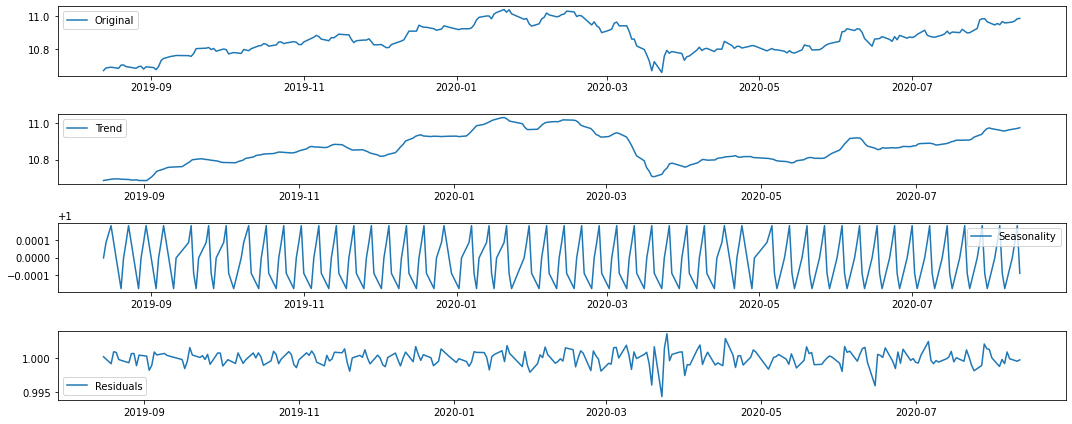

In [41]:
ts_log_residual = do_ts_decomposition(ts_log, 5)
ts_log_residual.dropna(inplace=True)

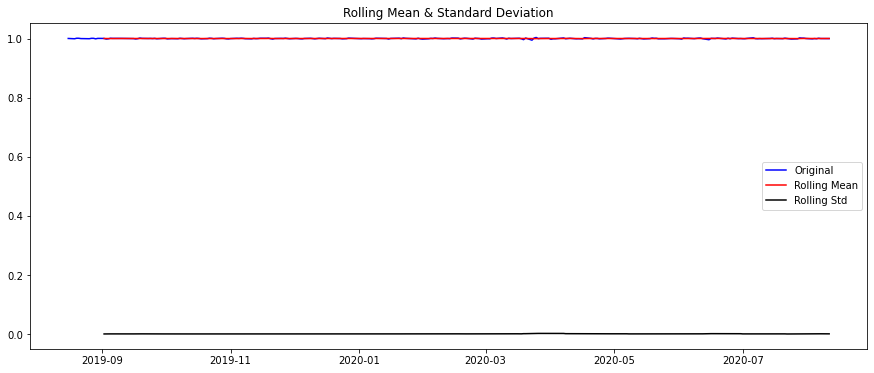

In [42]:
plot_rolling_statistics(ts_log_residual)

In [43]:
augmented_dickey_fuller_test(ts_log_residual)

Results of Dickey-Fuller Test:
Test Statistic                -7.935495e+00
p-value                        3.422440e-12
#Lags Used                     1.300000e+01
Number of Observations Used    2.310000e+02
Critical Value (1%)           -3.458980e+00
Critical Value (5%)           -2.874135e+00
Critical Value (10%)          -2.573482e+00
dtype: float64


# 4. Split dataset

In [53]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

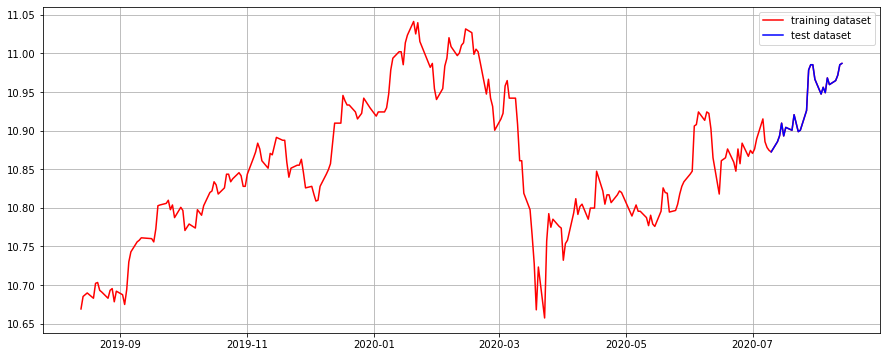

In [62]:
plt.figure()
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# 5. Find parameter for ARIMA

### get p,q - ACF/PACF

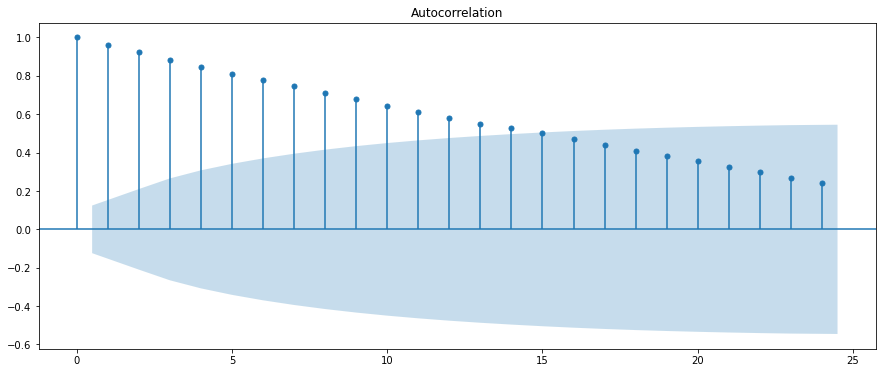

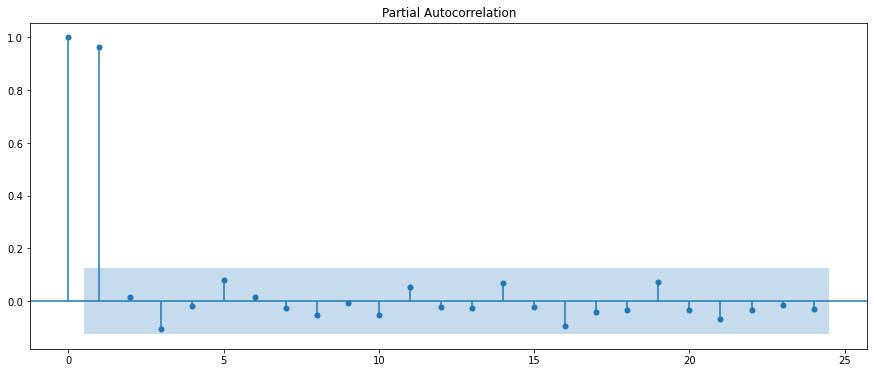

In [45]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

### get d - 차분 안정성 확인

Results of Dickey-Fuller Test:
Test Statistic                -9.689263e+00
p-value                        1.148139e-16
#Lags Used                     1.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


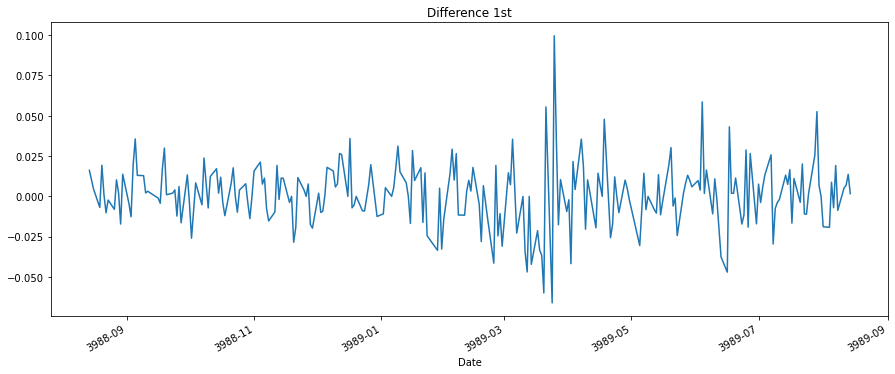

In [50]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -7.958840e+00
p-value                        2.986292e-12
#Lags Used                     1.400000e+01
Number of Observations Used    2.320000e+02
Critical Value (1%)           -3.458855e+00
Critical Value (5%)           -2.874080e+00
Critical Value (10%)          -2.573453e+00
dtype: float64


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


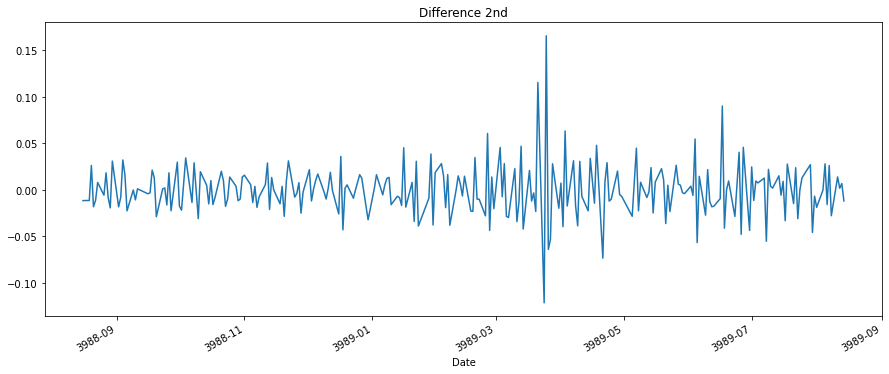

In [52]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# 6. Train ARIMA model

In [63]:
from statsmodels.tsa.arima_model import ARIMA

In [79]:
model = ARIMA(train_data, order=(1, 1, 0))   #p,d,q
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.Adj Close   No. Observations:                  223
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 554.274
Method:                       css-mle   S.D. of innovations              0.020
Date:                Thu, 13 Aug 2020   AIC                          -1102.547
Time:                        11:48:03   BIC                          -1092.326
Sample:                             1   HQIC                         -1098.421
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0009      0.001      0.704      0.481      -0.002       0.003
ar.L1.D.Adj Close    -0.0343      0.067     -0.513      0.608      -0.165       0.097
                        

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


# 7. Test a model

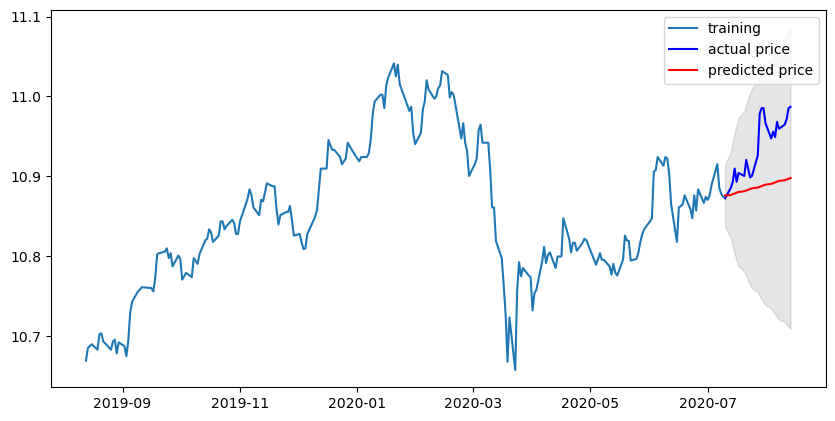

In [78]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [75]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

def cheak_error(_predict, _y):
    mse = mean_squared_error(np.exp(_y), np.exp(_predict))
    print('MSE: ', mse)

    mae = mean_absolute_error(np.exp(_y), np.exp(_predict))
    print('MAE: ', mae)

    rmse = math.sqrt(mean_squared_error(np.exp(_y), np.exp(_predict)))
    print('RMSE: ', rmse)

    mape = np.mean(np.abs(np.exp(_predict) - np.exp(_y))/np.abs(np.exp(_y)))
    print('MAPE: {:.2f}%'.format(mape*100))

In [80]:
cheak_error(fc, test_data)

MSE:  10826438.783668078
MAE:  2789.18480854637
RMSE:  3290.3554190494497
MAPE: 4.85%


# 8. Apply to another dataset

In [141]:
def get_graphs_train_test(_data, ratio):
    df = _data
    ts = pd.Series(df[col_name])
    ts = ts.interpolate(method='time')
    ts = np.log(ts)
    
    train_data, test_data = ts[:int(len(ts)*ratio)], ts[int(len(ts)*ratio):]
    
    plt.figure()
    plt.grid(True)
    plt.plot(ts, c='r', label='training dataset')
    plt.plot(test_data, c='b', label='test dataset')
    plt.legend()
    plt.show()
    
    plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
    plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
    plt.show()
    
    return train_data, test_data

In [142]:
def get_ARIMA(_train_data, _test_data, _p,_d,_q):
    model = ARIMA(_train_data, order=(_p, _d, _q))   #p,d,q
    fitted_m = model.fit(disp=-1)  
    print(fitted_m.summary())
    
    # Forecast : 결과가 fc에 담깁니다. 
    fc, se, conf = fitted_m.forecast(len(_test_data), alpha=0.05)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=_test_data.index)   # 예측결과
    lower_series = pd.Series(conf[:, 0], index=_test_data.index)  # 예측결과의 하한 바운드
    upper_series = pd.Series(conf[:, 1], index=_test_data.index)  # 예측결과의 상한 바운드

    # Plot
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(_train_data, label='training')
    plt.plot(_test_data, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
    plt.legend()
    plt.show()
    
    print("=============================  ERROR  =============================")
    cheak_error(fc, _test_data)

### predict Apple.INC

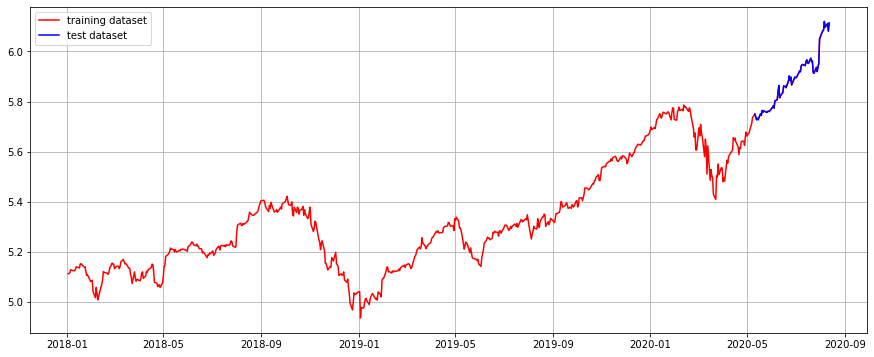

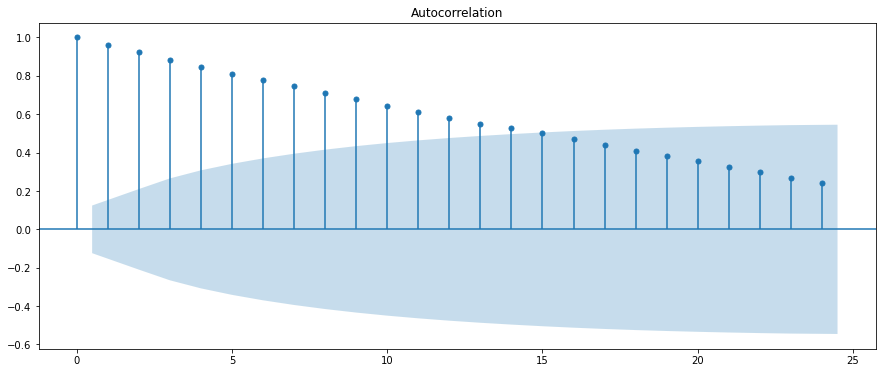

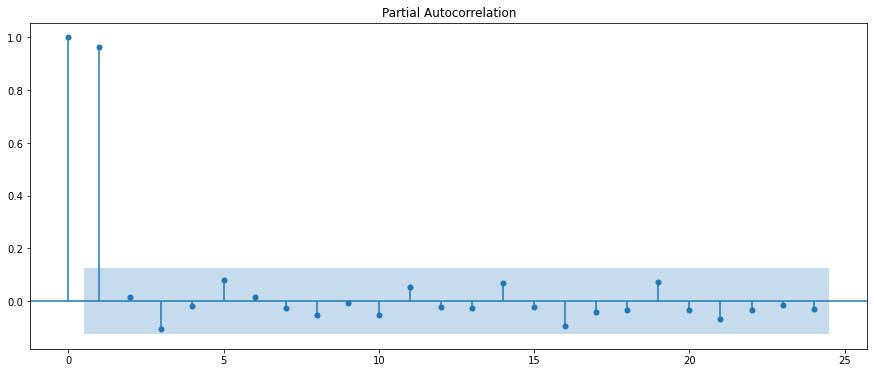

In [209]:
path = '~/aiffel/dataset/E6_stock_prediction/AAPL.csv'
col_name = 'Adj Close'
apple_df = pd.read_csv(path, index_col='Date', parse_dates=True)
apple_df = apple_df['2018-01-01':]

train_data, test_data = get_graphs_train_test(apple_df, 0.9)

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:            D.Adj Close   No. Observations:                  591
Model:                 ARIMA(1, 1, 0)   Log Likelihood                1433.211
Method:                       css-mle   S.D. of innovations              0.021
Date:                Thu, 13 Aug 2020   AIC                          -2860.422
Time:                        13:31:24   BIC                          -2847.276
Sample:                             1   HQIC                         -2855.301
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0010      0.001      1.405      0.160      -0.000       0.003
ar.L1.D.Adj Close    -0.1801      0.040     -4.451      0.000      -0.259      -0.101
                        

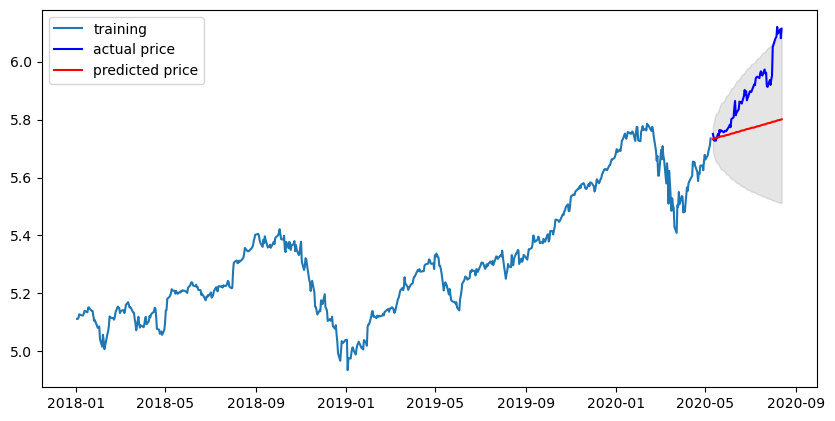

=============================  ERROR  =============================
MSE:  3059.376543124044
MAE:  43.286150413262554
RMSE:  55.31163117395874
MAPE: 11.07%


In [210]:
get_ARIMA(train_data, test_data, 1,1,0)

### predict NVIDIA.Inc

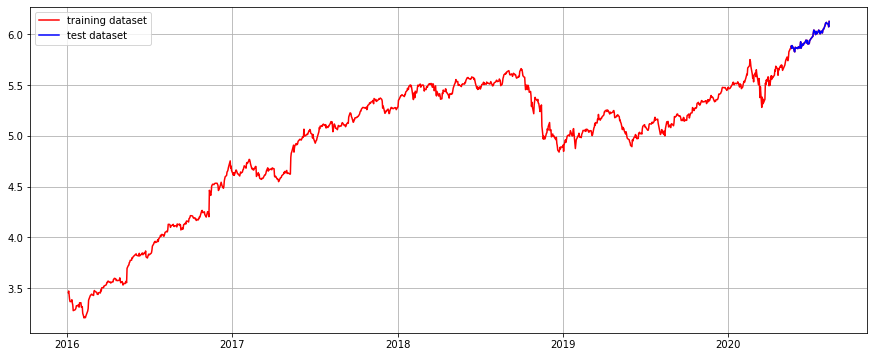

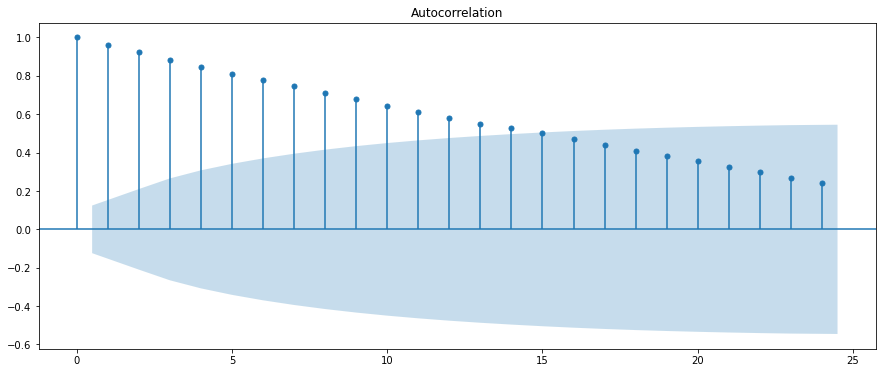

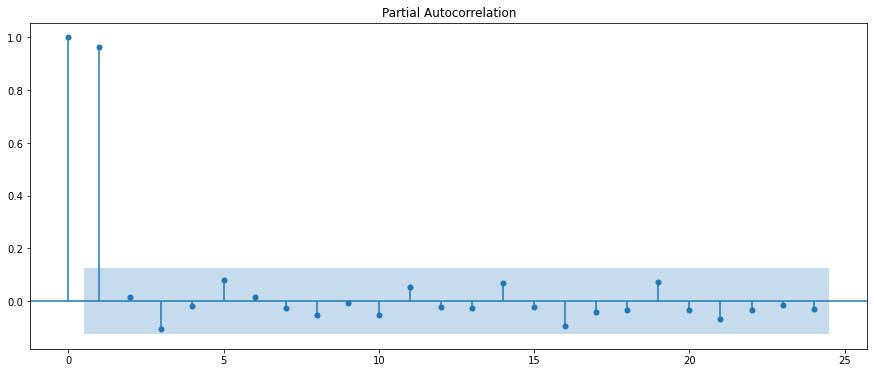

In [139]:
path = '~/aiffel/dataset/E6_stock_prediction/NVDA.csv'
col_name = 'Adj Close'
nvidia_df = pd.read_csv(path, index_col='Date', parse_dates=True)
nvidia_df = nvidia_df['2016-01-01':]

train_data, test_data = get_graphs_train_test(nvidia_df, 0.95)

                             ARIMA Model Results                              
Dep. Variable:            D.Adj Close   No. Observations:                 1101
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2296.605
Method:                       css-mle   S.D. of innovations              0.030
Date:                Thu, 13 Aug 2020   AIC                          -4587.211
Time:                        12:21:07   BIC                          -4572.199
Sample:                             1   HQIC                         -4581.532
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0022      0.001      2.673      0.008       0.001       0.004
ar.L1.D.Adj Close    -0.1078      0.030     -3.598      0.000      -0.166      -0.049
                        

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


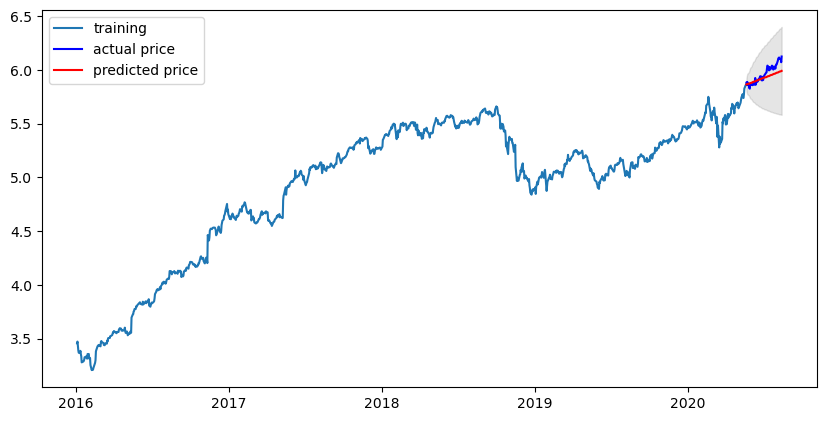

=============================  ERROR  =============================
MSE:  632.6771554936885
MAE:  19.15706007462193
RMSE:  25.153074473982073
MAPE: 4.63%


In [140]:
get_ARIMA(train_data, test_data, 1,1,0)

### predict Microsoft.Inc

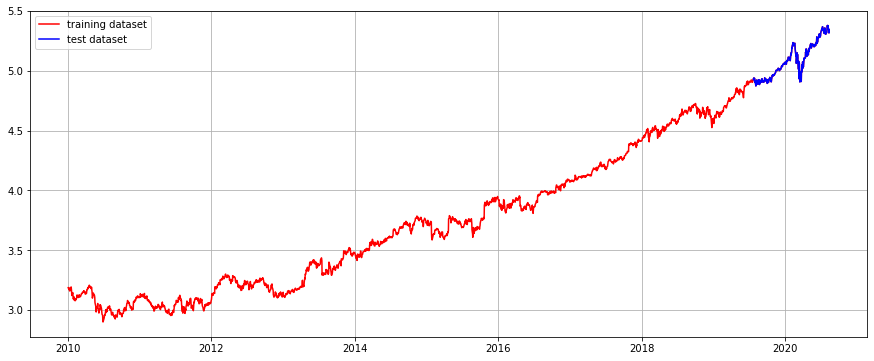

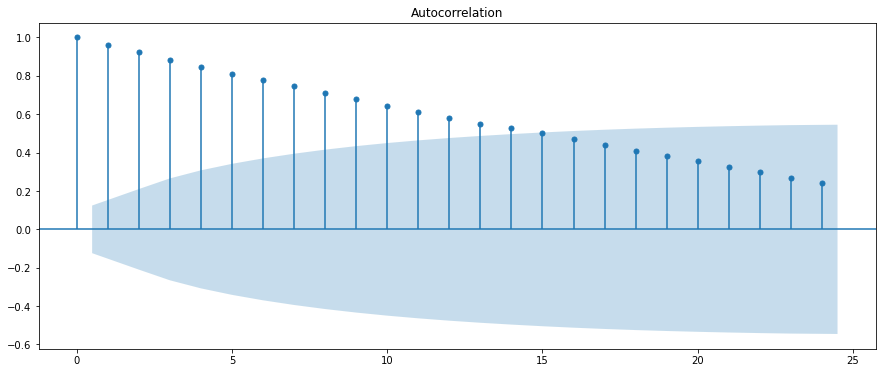

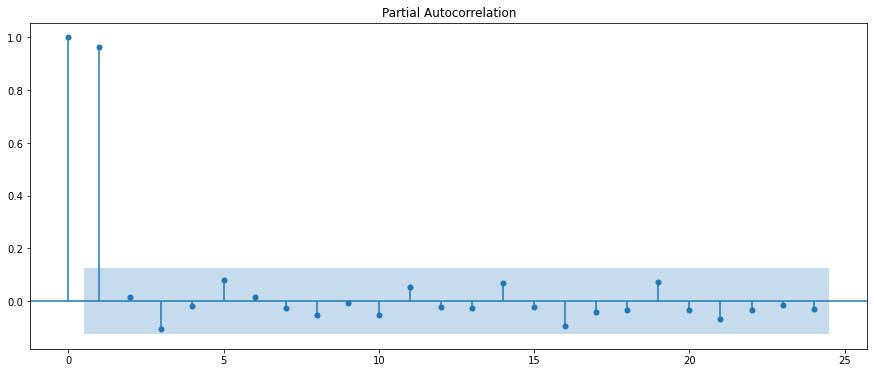

In [192]:
path = '~/aiffel/dataset/E6_stock_prediction/MSFT.csv'
col_name = 'Adj Close'
MSFT_df = pd.read_csv(path, index_col='Date', parse_dates=True)
MSFT_df = MSFT_df['2010-01-01':]

train_data, test_data = get_graphs_train_test(MSFT_df, 0.9)

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:            D.Adj Close   No. Observations:                 2402
Model:                 ARIMA(1, 1, 0)   Log Likelihood                6775.488
Method:                       css-mle   S.D. of innovations              0.014
Date:                Thu, 13 Aug 2020   AIC                         -13544.975
Time:                        13:29:36   BIC                         -13527.623
Sample:                             1   HQIC                        -13538.663
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0007      0.000      2.527      0.012       0.000       0.001
ar.L1.D.Adj Close    -0.0315      0.020     -1.544      0.123      -0.071       0.008
                        

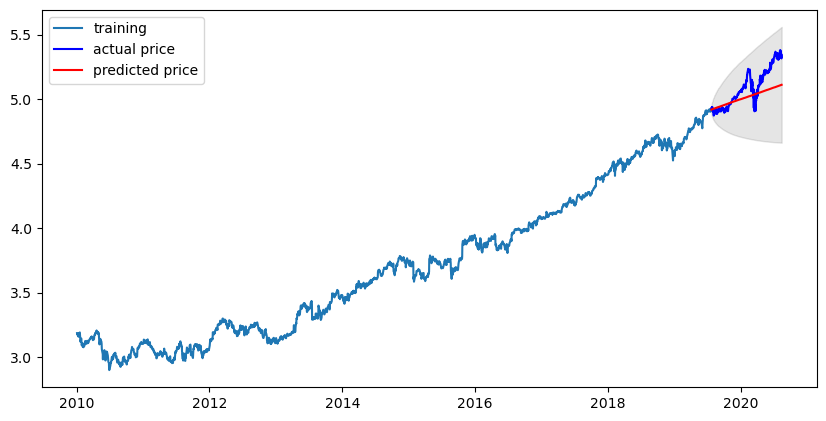

=============================  ERROR  =============================
MSE:  452.96444343956654
MAE:  15.739987129082838
RMSE:  21.282961340931074
MAPE: 8.68%


In [193]:
get_ARIMA(train_data, test_data, 1,1,0)

### predict Amazon.Inc

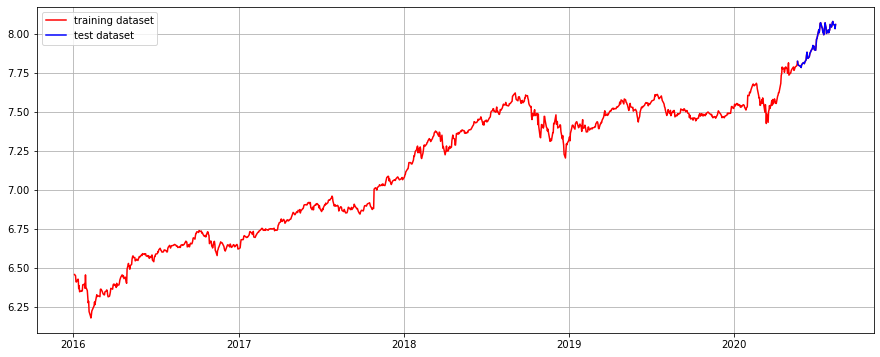

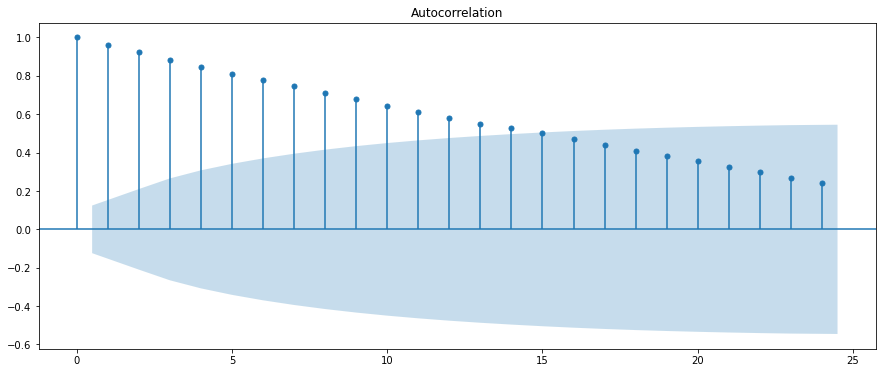

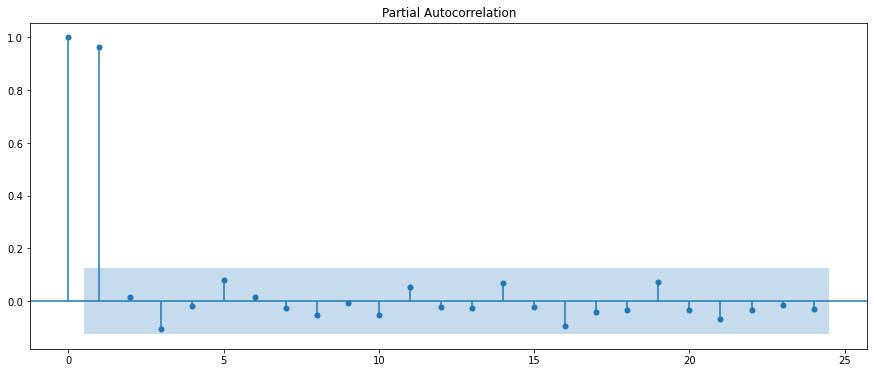

In [187]:
path = '~/aiffel/dataset/E6_stock_prediction/AMZN.csv'
col_name = 'Adj Close'
amazon_df = pd.read_csv(path, index_col='Date', parse_dates=True)
amazon_df = amazon_df['2016-01-01':]

train_data, test_data = get_graphs_train_test(amazon_df, 0.95)

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:            D.Adj Close   No. Observations:                 1101
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2826.185
Method:                       css-mle   S.D. of innovations              0.019
Date:                Thu, 13 Aug 2020   AIC                          -5646.371
Time:                        13:29:01   BIC                          -5631.359
Sample:                             1   HQIC                         -5640.692
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0012      0.001      2.315      0.021       0.000       0.002
ar.L1.D.Adj Close    -0.0598      0.030     -1.988      0.047      -0.119      -0.001
                        

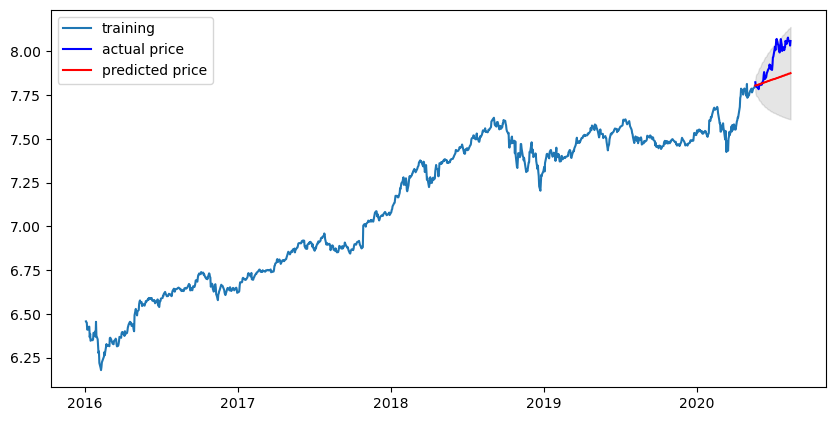

=============================  ERROR  =============================
MSE:  135342.76305720315
MAE:  297.9517982761843
RMSE:  367.8896071611743
MAPE: 9.88%


In [190]:
get_ARIMA(train_data, test_data, 1,1,0)

### MAPE per company

- Apple: 11.07%
- NVIDIA: 4.63%
- Microsoft: 8.68%
- NVIDIA: 9.88%